In [2]:
from scipy.integrate import odeint
from scipy.integrate import DOP853
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings
#import humanizer_portugues as hp
import seaborn as sns
from datetime import timedelta
warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
def seqiahr(y,t,*params):
    S,E,I,A,H,R,C,M = y
    chi,phi,beta,rho,delta,alpha,mu,p,q,r = params
    lamb = beta*(I+A)
    chi *= ((1+np.tanh(t-q))/2) * ((1 - np.tanh(t - (q+r))) / 2 )
    return[
        -lamb*((1-chi)*S), #dS/dt
        lamb*((1-chi)*S) - alpha*E,#dE/dt
        (1-p)*alpha*E - delta*I,#dI/dt
        p*alpha*E - delta*A,
        phi*delta*I -(rho+mu)*H,#dH/dt
        (1-phi)*delta*I + rho*H+delta*A ,#dR/dt
        phi*delta*I,#(1-p)*alpha*E+ p*alpha*E # Casos acumulados
        mu*H  #Mortes acumuladas
    ]

### Dados Brasil

In [15]:
cases = pd.read_csv('covid19_18_06.csv')
# Pegando os casos do Brasil.io
# cases = pd.read_csv('https://brasil.io/dataset/covid19/caso_full/?format=csv')
cases.date = pd.to_datetime(cases.date)

In [18]:
df_states = cases[cases.place_type!='state'].groupby(['date','state']).sum()
df_states.reset_index(inplace=True)

df_states = df_states.rename(columns={'date': 'Data'})
df_states.set_index('Data', inplace=True)

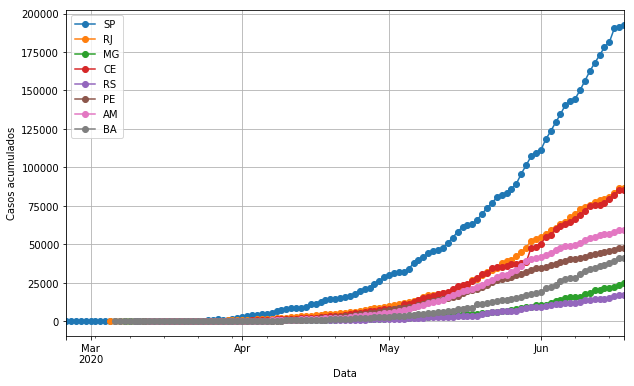

In [19]:
# df_states.set_index('date', inplace=True)
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.set_ylabel('Casos acumulados')

for uf in ['SP','RJ','MG','CE','RS', 'PE', 'AM', 'BA']:
    df_states[df_states.state==uf].last_available_confirmed.plot(ax=ax,style='-o', label=uf, grid=True)

ax.legend()
#plt.savefig('Casos_confirmados_estados.png',dpi=200)

In [14]:
df_states

,state,epidemiological_week,order_for_place,city_ibge_code,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,new_confirmed,last_available_deaths,new_deaths,last_available_death_rate,estimated_population_2019,is_last,is_repeated
date,,,,,,,,,,,,,
2020-02-25,SP,9,1,3.550308e+06,1,0.00816,1,0,0,0.0000,12252023.0,0.0,0.0
2020-02-26,SP,9,2,3.550308e+06,1,0.00816,0,0,0,0.0000,12252023.0,0.0,0.0
2020-02-27,SP,9,3,3.550308e+06,1,0.00816,0,0,0,0.0000,12252023.0,0.0,0.0
2020-02-28,SP,9,4,3.550308e+06,2,0.01632,1,0,0,0.0000,12252023.0,0.0,0.0
2020-02-29,SP,9,5,3.550308e+06,2,0.01632,0,0,0,0.0000,12252023.0,0.0,0.0
2020-03-01,SP,10,6,3.550308e+06,2,0.01632,0,0,0,0.0000,12252023.0,0.0,0.0
2020-03-02,SP,10,7,3.550308e+06,2,0.01632,0,0,0,0.0000,12252023.0,0.0,0.0
2020-03-03,SP,10,8,3.550308e+06,2,0.01632,0,0,0,0.0000,12252023.0,0.0,0.0
2020-03-04,SP,10,9,3.550308e+06,3,0.02449,1,0,0,0.0000,12252023.0,0.0,0.0


In [6]:
def casos_estado_covid(estado, cases):
    casos = cases[(cases.state == estado)].reset_index()[['date', 'last_available_confirmed', 'last_available_deaths']]
    casos['data'] = pd.to_datetime(casos.date)
    casos.set_index('data', inplace=True)
    casos.sort_index(inplace=True)
    casos['incidencia_casos'] = casos.last_available_deaths.diff()
    casos['incidencia_morte'] = casos.last_available_confirmed.diff()
    #casos['ew'] = [int(episem.episem(x, out='W')) for x in casos.index]
    casos.to_csv(f'dados_{estado}.csv')
    return casos

estados = set(df_states.state)
for uf in estados:
    casos_estado_covid(uf,df_states)


In [7]:
casos_estados = df_states[['state','new_confirmed','last_available_confirmed', 'new_deaths','last_available_deaths']]
casos_estados = casos_estados.reset_index()
casos_estados.columns = ['data','estado','casosNovos','casosAcumulados','obitosNovos','obitosAcumulados']
casos_estados = casos_estados.groupby(['data','estado']).sum()
casos_estados

,,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados
data,estado,,,,
2020-02-25,SP,1,1,0,0
2020-02-26,SP,0,1,0,0
2020-02-27,SP,0,1,0,0
2020-02-28,SP,1,2,0,0
2020-02-29,SP,0,2,0,0
2020-03-01,SP,0,2,0,0
2020-03-02,SP,0,2,0,0
2020-03-03,SP,0,2,0,0
2020-03-04,SP,1,3,0,0


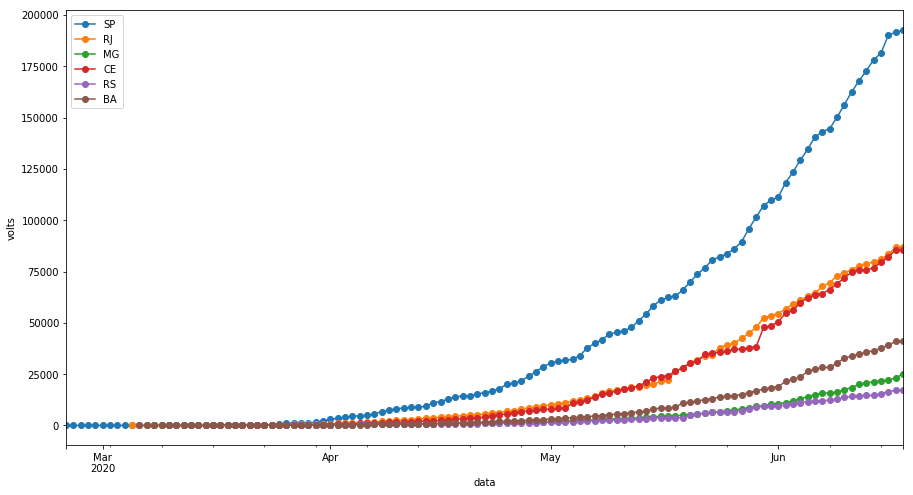

In [8]:
fig,ax = subplots(1,1,figsize=(15,8))
casos_estados.reset_index(inplace=True)
casos_estados.set_index('data', inplace=True)
for uf in ['SP','RJ','MG','CE','RS', 'BA']:
    casos_estados[casos_estados.estado==uf].casosAcumulados.plot(style='-o', label=uf)

ax.legend()

In [9]:
trange = arange(0,1095,1)
χ=0.0;φ=.1;β=.5;ρ=.6;δ=.1;α=.53; p=.75; q=-2; mu=0.02; r=1000
inits = [0.99,0,1.0277e-8, 0.0,0,0,0,0]
res = odeint(seqiahr,inits,trange,args=(χ,φ,β,ρ,δ,α,mu,p,q,r))
# Com controle
χ=0.1;β=.17
res_c = odeint(seqiahr,inits,trange,args=(χ,φ,β,ρ,δ,α,mu,p,q, r))
plt.plot(trange,res[:,-1],label='no control');
plt.plot(trange,res_c[:,-1],label='with control');
plt.legend();

NameError: name 'seqiahr' is not defined

In [ ]:
df_brasil = casos_estados.groupby('data').sum()

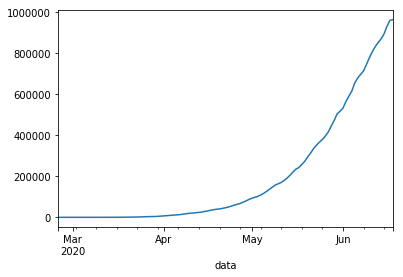

In [23]:
df_brasil.casosAcumulados.plot();

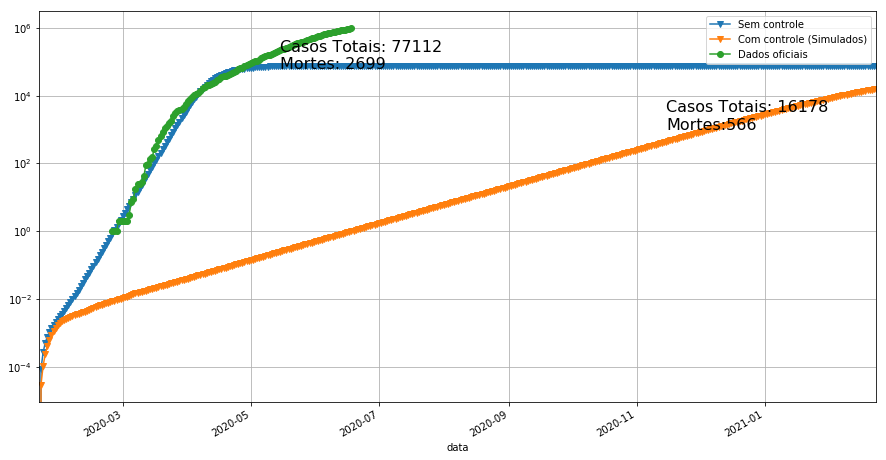

In [26]:
N = 97.3e6
dias=400
fat = 0.035
offset = 35 # quantos dias antes do primeiro caso notificado devemos começar a simulaçao
drange = pd.date_range(df_brasil[df_brasil.casosAcumulados>0].index.min()-timedelta(offset),periods=dias,freq='D')
# df_states.reset_index(inplace=True)
# df_brasil = df_states.groupby('date').sum()
fig,ax = subplots(1,1,figsize=(15,8))
ax.plot(drange,res[:dias,-1]*N,'-v', label='Sem controle')
# ax.plot(drange,res[:dias,-3]*N,'-v', label='Hosp')
# ax.vlines('2020-05-5',0,1e6)
ax.plot(drange,res_c[:dias,-1]*N,'-v', label='Com controle (Simulados)')
# ax.plot(drange,res[:dias,2]*N,'-^', label='Prevalência')
df_brasil[df_brasil.casosAcumulados>0].casosAcumulados.plot(ax=ax, style='-o', 
                                                            label='Dados oficiais',
                                                            grid=True, 
                                                            logy=True)
# Sem controle
ax.text('2020-05-15',0.6e5, f'Casos Totais: {res[dias,-1]*N:.0f}\nMortes: {res[dias,-1]*N*fat:.0f}', 
        fontsize=16)
# com 10% quarentena e R0=1.7
ax.text('2020-11-15',1e3, f'Casos Totais: {res_c[dias,-1]*N:.0f}\nMortes:{res_c[dias,-1]*N*fat:.0f}', 
        fontsize=16)
ax.legend();
# plt.savefig('export/Casos_vs_Projeções_log.png',dpi=200)

#### Simulação SP

#### Simulação RJ